In [16]:
import os
import torch
import pandas as pd
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm

# Ensure that your notebook can find the Dataset and Model classes:
# you can either add that folder to PYTHONPATH or copy the files into the notebook directory.
import sys
sys.path.append('.')  # Adjust this path if the files are located in a subdirectory

# Now import the Dataset and Model
from src.dataloader import SimpleTokenDataset
from src.transformer import SANETokenAutoencoder

# GPU stability settings (optional but recommended)
# Disable Flash Attention to avoid potential compatibility issues
os.environ["PYTORCH_ENABLE_FLASH_ATTN"] = "0"
# Make CUDA operations deterministic for reproducibility
torch.backends.cudnn.deterministic = True
# Disable CuDNN benchmark mode to prevent dynamic algorithm selection (ensures consistent behavior)
torch.backends.cudnn.benchmark     = False


In [17]:
# -----------------------------------------------------------------------------
# Paths to Token and Position Files
# -----------------------------------------------------------------------------
# Directory containing token/position data files. Adjust this path if your data
# resides elsewhere.
token_dir = "prepared_objects_first_4_levels"

# List of model identifier strings corresponding to the directories or checkpoint
# names you want to load. Update this list if you have multiple models or 
# different naming conventions.
model_ids = ["GoldBag__y_000_180_000__checkpoints__final"]

# -----------------------------------------------------------------------------
# Window Size and Batch Size
# -----------------------------------------------------------------------------
# The length of each input window (number of tokens) that the model processes.
window_size = 256

# Number of samples to load per batch during training or evaluation.
batch_size = 8


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# -----------------------------------------------------------------------------
# Checkpoint File Path
# -----------------------------------------------------------------------------
# Path to a saved model checkpoint file (e.g., "checkpoint_epoch05.pt"). This is
# used to resume training or perform inference from a previously saved state.
checkpoint_path = "checkpoints/checkpoint_epoch05.pt"


In [18]:
# Ensure that SimpleTokenDataset provides the fields:
# 'tokens', 'abs_norm', 'p_norm', and 'levels'.
dataset = SimpleTokenDataset(
    token_dir=token_dir,    # Directory where token/position files are stored
    model_ids=model_ids,    # List of model identifiers to load data from
    window_size=window_size,# Number of tokens per input window
    augment=False           # Disable any data augmentation when evaluating
)

# Wrap the dataset in a DataLoader for batching and parallel data loading.
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,  # Number of samples per batch
    shuffle=True,           # Enable shuffling of data each epoch
                            # (If evaluating without randomness, set to False)
    num_workers=4,          # Spawn 4 subprocesses to load data in parallel
    pin_memory=True         # Copy tensors into CUDA pinned memory before returning
                            # (speeds up host-to-GPU transfers)
)

# Print out the total number of windows in the dataset
print(f"Dataset size (number of windows): {len(dataset)}")
# Print out how many batches are created given the batch size
print(f"Number of batches (batch_size={batch_size}): {len(dataloader)}")


Dataset size (number of windows): 125313
Number of batches (batch_size=8): 15665


/home/roman/Instant-NGP-Sane/src/dataloader.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tokens = torch.load(tpath).float()
/home/roman/Instant-NGP-Sane/src/dataload

In [19]:
# Instantiate the SANETokenAutoencoder model with specified hyperparameters:
# - token_dim: Dimensionality of each input token (e.g., 2 for (x, y) coordinates)
# - d_model: Feature dimension inside the Transformer layers
# - nhead: Number of attention heads in each multi-head attention layer
# - num_layers: Number of Transformer encoder/decoder layers
# - dim_feedforward: Hidden dimension of the feedforward sublayers
# - dropout: Dropout probability to use between layers
# - level_embed_dim: Embedding dimension for the 'levels' feature
model = SANETokenAutoencoder(
    token_dim=2,
    d_model=64,
    nhead=4,
    num_layers=2,
    dim_feedforward=256,
    dropout=0.1,
    level_embed_dim=16
).to(device)  # Move the model to the selected device (GPU or CPU)

# Verify that the checkpoint file exists before attempting to load it
if not os.path.isfile(checkpoint_path):
    raise FileNotFoundError(f"Checkpoint file '{checkpoint_path}' not found.")

# Load the checkpoint's state dictionary, mapping tensors to the correct device
state_dict = torch.load(checkpoint_path, map_location=device)
# Load the weights into the model
model.load_state_dict(state_dict)
# Set the model to evaluation mode (disables dropout, uses running stats for batchnorm, etc.)
model.eval()

print(f"Checkpoint '{checkpoint_path}' loaded. Model set to evaluation mode.")


Checkpoint 'checkpoints/checkpoint_epoch05.pt' loaded. Model set to evaluation mode.


/tmp/ipykernel_3804/2346567423.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location=device)


In [20]:
with torch.no_grad():  # Disable gradient computation for evaluation
    for batch in tqdm(dataloader, desc="Evaluating reconstruction", unit="Batch"):
        # Move each field in the batch to the selected device (GPU or CPU)
        tokens   = batch["tokens"].to(device)   # Shape: [B, W, 2]
        abs_norm = batch["abs_norm"].to(device) # Shape: [B, W, 1]
        p_norm   = batch["p_norm"].to(device)   # Shape: [B, W, 1]
        levels   = batch["levels"].to(device)   # Shape: [B, W]

        # Forward pass through the model to reconstruct the input tokens
        recon = model(tokens, abs_norm, p_norm, levels)  # Output shape: [B, W, 2]

        # Compute MSE per token (no reduction) to get a tensor of shape [B, W, 2]
        mse_per_token = F.mse_loss(recon, tokens, reduction="none")  # [B, W, 2]
        # Average MSE across both token dimensions (W and 2) to get one value per window
        mse_per_window = mse_per_token.mean(dim=(1, 2))  # Shape: [B]
        # Compute the average MSE across all windows in this batch
        avg_mse = mse_per_window.mean().item()

        print(f"\nAverage MSE over the first batch: {avg_mse:.6e}\n")
        break  # Only process the first batch


Evaluating reconstruction:   0%|          | 0/15665 [00:00<?, ?Batch/s]


Average MSE over the first batch: 7.122035e-06



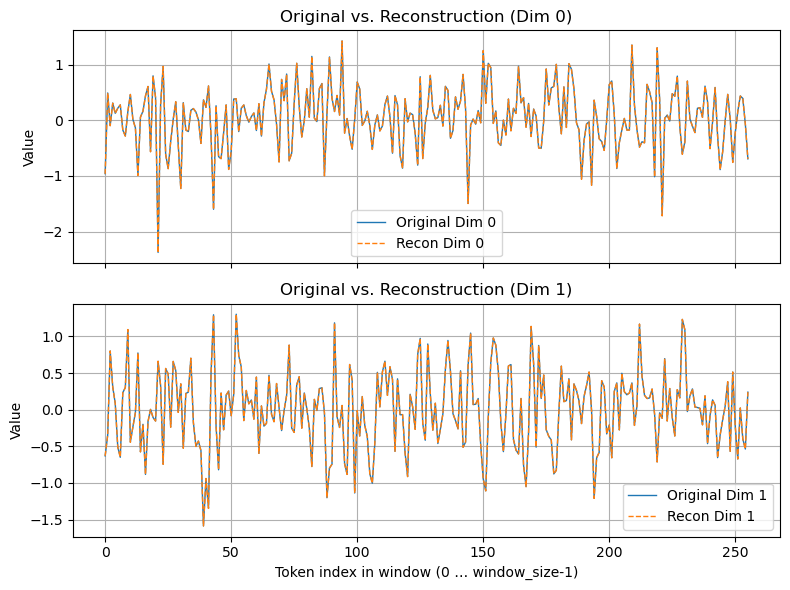

In [21]:
# Select the first window in the batch (window_idx = 0)
window_idx = 0

# The 'tokens' and 'recon' tensors have shape [B, W, 2].
# Move them to CPU and reshape explicitly to [batch_size, window_size, 2] 
orig_batch = tokens.cpu().view(batch_size, window_size, 2)
recon_batch = recon.cpu().view(batch_size, window_size, 2)

# Extract the first window (index 0) from both original and reconstructed batches.
# Each window has shape [window_size, 2].
orig_window = orig_batch[window_idx]    # Shape: [W, 2]
recon_window = recon_batch[window_idx]  # Shape: [W, 2]

# Create a figure with two subplots (one for each token dimension).
# figsize=(8, 6) sets the overall figure size in inches.
# sharex=True makes the x-axis shared between the two plots.
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Prepare the x-axis values: a list from 0 to window_size-1
x_axis = list(range(window_size))

# --- Plot for Dimension 0 ---
# Plot the original token values in dimension 0 as a solid line.
axes[0].plot(x_axis, orig_window[:, 0], label="Original Dim 0", linewidth=1)
# Plot the reconstructed token values in dimension 0 as a dashed line.
axes[0].plot(x_axis, recon_window[:, 0], "--", label="Recon Dim 0", linewidth=1)
axes[0].set_ylabel("Value")            # Label for the y-axis
axes[0].set_title("Original vs. Reconstruction (Dim 0)")  # Title of the subplot
axes[0].legend()                        # Show legend
axes[0].grid(True)                      # Enable grid lines for readability

# --- Plot for Dimension 1 ---
# Plot the original token values in dimension 1 as a solid line.
axes[1].plot(x_axis, orig_window[:, 1], label="Original Dim 1", linewidth=1)
# Plot the reconstructed token values in dimension 1 as a dashed line.
axes[1].plot(x_axis, recon_window[:, 1], "--", label="Recon Dim 1", linewidth=1)
axes[1].set_xlabel("Token index in window (0 … window_size-1)")  # Label for the x-axis
axes[1].set_ylabel("Value")            # Label for the y-axis
axes[1].set_title("Original vs. Reconstruction (Dim 1)")  # Title of the subplot
axes[1].legend()                        # Show legend
axes[1].grid(True)                      # Enable grid lines

# Adjust subplot layouts to prevent overlap and make the figure look neat.
plt.tight_layout()
# Display the figure with both subplots.
plt.show()


In [9]:
# Attempt to use `tokens`, `recon`, and `levels` from the current workspace.
# If they do not exist, generate dummy data instead.
try:
    # Retrieve batch size (B), window size (W), and token dimension (_) from `tokens`
    B, W, _ = tokens.shape   # batch_size, window_size, token_dim

    # Move tensors to CPU, reshape to [B, W, 2], and convert to NumPy arrays
    original_batch = tokens.cpu().view(B, W, 2).numpy()  
    recon_batch    = recon.cpu().view(B, W, 2).numpy()  
    levels_batch   = levels.cpu().view(B, W).numpy()    # Shape: [B, W]

    # Select the first window in the batch (index 0)
    window_idx = 0
    orig_window  = original_batch[window_idx]  # Shape: [W, 2]
    recon_window = recon_batch[window_idx]     # Shape: [W, 2]
    level_window = levels_batch[window_idx]    # Shape: [W]

except NameError:
    # If `tokens`, `recon`, or `levels` are not found, create dummy data
    W = 256  # Window size
    # Generate random original token values [W, 2]
    orig_window = np.random.randn(W, 2)
    # Create reconstructed values by adding small Gaussian noise
    recon_window = orig_window + (np.random.randn(W, 2) * 0.01)  
    # Create dummy levels, all set to 0
    level_window = np.zeros(W, dtype=int)  

# Build a pandas DataFrame with five columns:
#   - orig_dim0: Original values for token dimension 0
#   - recon_dim0: Reconstructed values for token dimension 0
#   - orig_dim1: Original values for token dimension 1
#   - recon_dim1: Reconstructed values for token dimension 1
#   - level:    Level index for each token in the window
df = pd.DataFrame({
    'orig_dim0': orig_window[:, 0],
    'recon_dim0': recon_window[:, 0],
    'orig_dim1': orig_window[:, 1],
    'recon_dim1': recon_window[:, 1],
    'level': level_window
})


In [10]:
df

,orig_dim0,recon_dim0,orig_dim1,recon_dim1,level
0,1.853257,1.854116,0.426887,0.428890,3
1,1.684812,1.685220,0.354280,0.356055,3
2,-1.179272,-1.181129,-0.240108,-0.240120,3
3,0.215013,0.214758,0.157082,0.157675,3
4,0.268241,0.268027,0.257190,0.257706,3
...,...,...,...,...,...
251,-0.124830,-0.125361,0.085000,0.085653,3
252,0.015853,0.015445,0.160297,0.160975,3
253,0.032632,0.032137,-0.003218,-0.002540,3
254,-0.141691,-0.142551,-0.158766,-0.158352,3


## Compare latent spaces of two objects